# 任务三
参考：https://blog.csdn.net/datawhale/article/details/80847662

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')

In [21]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
train_data.head()

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,0.01,0.99,4000,0.96,1.00,0.405,16.0,29.0,28.0,1.0,...,5000.0,1845.0,10600.0,81.0,7.0,7.0,15600.0,8228.0,0.0,9.0
1,0.03,0.97,500,0.87,1.00,0.205,18.0,27.0,27.0,3.0,...,2600.0,1800.0,16300.0,78.0,5.0,5.0,21600.0,7160.0,30.0,27.0
2,0.02,0.86,0,1.98,0.70,0.205,18.0,53.0,33.0,2.0,...,2300.0,1500.0,10400.0,82.0,5.0,5.0,13800.0,10320.0,3.0,137.0
3,0.02,0.81,1000,1.49,0.73,0.555,23.0,15.0,8.0,4.0,...,4500.0,2500.0,6600.0,78.0,11.0,12.0,17400.0,6418.0,20.0,51.0
4,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0


In [22]:
feature_iv = open('./data/feature_iv.txt', 'r')
list_selected_features = list()
for fin in feature_iv:
    feature,iv = fin.strip().split(';')
    if 0.02<= float(iv)<0.5 :
        list_selected_features.append(feature)
list_selected_features

['latest_six_month_apply',
 'loans_settle_count',
 'trans_day_last_12_month',
 'trans_fail_top_count_enum_last_12_month',
 'trans_fail_top_count_enum_last_6_month',
 'latest_one_month_suc',
 'history_fail_fee',
 'rank_trad_1_month',
 'max_cumulative_consume_later_1_month',
 'first_transaction_day',
 'trans_top_time_last_1_month',
 'pawns_auctions_trusts_consume_last_1_month',
 'top_trans_count_last_1_month',
 'consfin_max_limit',
 'trans_amount_3_month',
 'loans_avg_limit',
 'latest_one_month_loan',
 'consume_top_time_last_1_month',
 'consfin_avg_limit',
 'avg_price_last_12_month',
 'latest_three_month_loan',
 'consfin_product_count',
 'query_sum_count',
 'avg_price_top_last_12_valid_month',
 'trans_days_interval',
 'trans_amount_increase_rate_lately',
 'query_finance_count',
 'loans_org_count_behavior',
 'consfin_credibility',
 'consfin_org_count_current']

In [23]:
y_train_origin = train_data['status']
X_train_origin = train_data[list_selected_features] # 使用 iv值选择的特征
y_test = test_data['status']
X_test = test_data[list_selected_features] # 使用 iv值选择的特征

### 标准化训练集的特征

In [24]:
X_scaler = StandardScaler()
X_train_origin = X_scaler.fit_transform(X_train_origin)

### 评分模型：NDCG

In [25]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """
    y_true : array, shape = [n_samples] #数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] #预测的分数
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] #分数从高到低排序
    y_true = np.take(y_true, order[:k]) #取出前k[0,k）个分数
      
    gain = 2 ** y_true - 1   

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
  

def ndcg_score(ground_truth, predictions, k=5):   
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)    
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

## 1.逻辑回归

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
lr = LogisticRegression(C = 1.0, penalty='l2', multi_class='ovr')

In [27]:
lr = LogisticRegression(C = 1.0, penalty='l2', multi_class='ovr')
RANDOM_STATE = 2018  #随机种子

#k-fold cross validation（k-折叠交叉验证）
kf = KFold(n_splits=5, random_state=RANDOM_STATE) #分成5个组
train_score = [] 
cv_score = []

# select a k  (value how many y):
k_ndcg = 3 
# kf.split: Generate indices to split data into training and test set.
for train_index, test_index in kf.split(X_train_origin, y_train_origin):
    #训练集数据分割为训练集和测试集，y是目标变量
    X_train, X_test = X_train_origin[train_index, :], X_train_origin[test_index, :]
    y_train, y_test = y_train_origin[train_index], y_train_origin[test_index]
        
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)
    
    train_score.append(train_ndcg_score)
    cv_score.append(cv_ndcg_score)
print ("\nThe training score is: {}".format(np.mean(train_score)))
print ("\nThe cv score is: {}".format(np.mean(cv_score)))


The training score is: 0.9209056318371474

The cv score is: 0.9180218891995577


## 2.SVM
根据核函数的不同，又分为：SVM-rbf，SVM-poly，SVM-linear等

In [28]:
from sklearn.svm import SVC, LinearSVC, NuSVC

In [29]:
TOL = 1e-4
MAX_ITER = 1000

clf_svm = {
    'SVM-rbf': SVC(kernel='rbf',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     
    
    'SVM-poly': SVC(kernel='poly',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     
    
    'SVM-linear': SVC(kernel='linear',
                      max_iter=MAX_ITER,
                      tol=TOL, 
                      random_state=RANDOM_STATE,
                      decision_function_shape='ovr'),  
    
    'LinearSVC': LinearSVC(max_iter=MAX_ITER,
                            tol=TOL,
                            random_state=RANDOM_STATE,
                            multi_class = 'ovr')  
}     

train_score_svm = []
cv_score_svm = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)
k_ndcg = 5

for key in clf_svm.keys():
    clf = clf_svm.get(key)
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(X_train_origin, y_train_origin):
        X_train, X_test = X_train_origin[train_index, :], X_train_origin[test_index, :]
        y_train, y_test = y_train_origin[train_index], y_train_origin[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.decision_function(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.decision_function(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score_svm.append(np.mean(train_score_iter))
    cv_score_svm.append(np.mean(cv_score_iter))
print(train_score_svm)
print(cv_score_svm)

[0.7493237150586114, 0.7493237150586114, 0.7493237150586114, 0.7493237150586114]
[0.7493237150586114, 0.7493237150586114, 0.7493237150586114, 0.7493237150586114]


In [30]:
import matplotlib.pyplot as plt

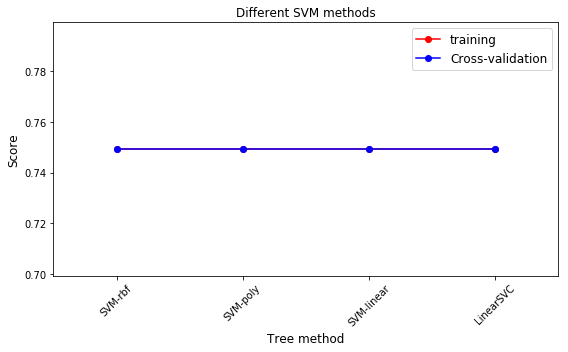

In [31]:
ymin = np.min(cv_score_svm)-0.05
ymax = np.max(train_score_svm)+0.05

x_ticks = clf_svm.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_svm, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_svm, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 3.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different SVM methods")

plt.tight_layout()

## 3.决策树和随机森林

In [37]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.svm import SVC, LinearSVC, NuSVC
LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2017
MAX_DEPTH = 9

In [38]:
#建了一个tree字典
clf_tree ={
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                    random_state=RANDOM_STATE),
    
    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                 max_depth=MAX_DEPTH,
                                 random_state=RANDOM_STATE),
    
    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                   learning_rate=LEARNING_RATE,
                                   random_state=RANDOM_STATE),
    
    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS,
                                 random_state=RANDOM_STATE),
    
    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH,
                                      n_estimators=N_ESTIMATORS,
                                      random_state=RANDOM_STATE),
    
    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH,
                                           n_estimators=N_ESTIMATORS,
                                           random_state=RANDOM_STATE)
}
train_score = []
cv_score = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_tree.keys():
    clf = clf_tree.get(key)
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(X_train_origin, y_train_origin):
        X_train, X_test = X_train_origin[train_index, :], X_train_origin[test_index, :]
        y_train, y_test = y_train_origin[train_index], y_train_origin[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))

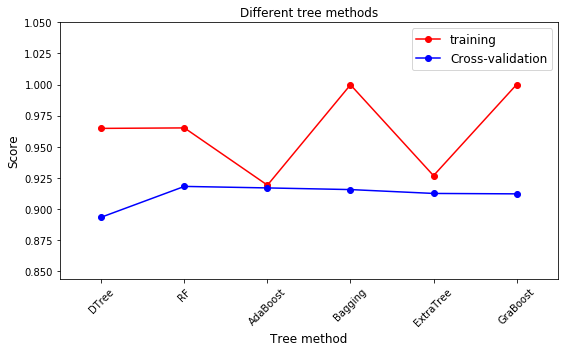

In [39]:
train_score_tree = train_score
cv_score_tree = cv_score

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = clf_tree.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_tree, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()

## 5.XGBoost

In [33]:
import xgboost as xgb

In [34]:
def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score
# xgboost parameters

NUM_XGB = 200

params = {}
params['colsample_bytree'] = 0.6
params['max_depth'] = 6
params['subsample'] = 0.8
params['eta'] = 0.3
params['seed'] = RANDOM_STATE
params['num_class'] = 12
params['objective'] = 'multi:softprob'   # output the probability instead of class. 
train_score_iter = []
cv_score_iter = []

kf = KFold(n_splits = 3, random_state=RANDOM_STATE)

k_ndcg = 5

for train_index, test_index in kf.split(X_train_origin, y_train_origin):
    X_train, X_test = X_train_origin[train_index, :], X_train_origin[test_index, :]
    y_train, y_test = y_train_origin[train_index], y_train_origin[test_index]
    
    train_xgb = xgb.DMatrix(X_train, label= y_train)
    test_xgb = xgb.DMatrix(X_test, label = y_test)
    
    watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]

    bst = xgb.train(params, 
                     train_xgb,
                     NUM_XGB,
                     watchlist,
                     feval = customized_eval,
                     verbose_eval = 3,
                     early_stopping_rounds = 5)
    
    
    #bst = xgb.train( params, dtrain, num_round, evallist )

    y_pred = np.array(bst.predict(test_xgb))
    y_pred_train = np.array(bst.predict(train_xgb))
    train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)

train_score_xgb = np.mean(train_score_iter)
cv_score_xgb = np.mean(cv_score_iter)

print ("\nThe training score is: {}".format(train_score_xgb))
print ("The cv score is: {}\n".format(cv_score_xgb))

[0]	train-merror:0.203336	test-merror:0.241659	train-ndcg5:0.924955	test-ndcg5:0.910811
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.151939	test-merror:0.224527	train-ndcg5:0.943924	test-ndcg5:0.917134
Stopping. Best iteration:
[0]	train-merror:0.203336	test-merror:0.241659	train-ndcg5:0.924955	test-ndcg5:0.910811

[0]	train-merror:0.188458	test-merror:0.225428	train-ndcg5:0.930446	test-ndcg5:0.916801
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.163661	test-merror:0.207394	train-ndcg5:0.939598	test-ndcg5:0.923457
Stopping. Best iteration:
[0]	train-merror:0.188458	test-merror:0.225428	train-ndcg5:0.930446	test-ndcg5:0.916801

[0]	train-merror:0.185302	test-merror:0.240757	train-ndcg5:0.931611	test-ndcg5:0.911144
Multiple eval metrics have been passed: 't